# CS-E4895: Gaussian Processes

## Assignment #3: Marginal likelihood, Model Selection, and Kernel Ridge Regression.

### Learning objectives

After completing the exercise, you should be able to:
- implement and use marginal likelihood for model selection.
- implement and use mean log posterior predictive density (MLPPD) for model selection.
- implement periodic kernel and study its properties.
- implement kernel ridge regression objective, and compare numerical vs analytical solution.


## Enter your student number

**STUDENT_NUMBER** = 202195

## Warnings:

- Don’t copy and paste cells within a notebook. This will mess up the tracking metadata and prevent autograding from working.
- Only add new cells using the '+' button in the upper toolbar and do not split cells.
- Be cautious about things such as copying the whole notebook to Colab to work on it. This has sometimes resulted in removing all notebook metadata, making autograding impossible.

In [3]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snb
from scipy.optimize import minimize
snb.set(font_scale=1.5)

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

In [4]:
automatic_grading = False  # Set this to True after completing the notebook and before submitting.

### Do not move or delete the below block. It is used for automatic grading.

### Task 1: The marginal likelihood (3 points)

The purpose of this task is to study the marginal likelihood $p(\mathbf{y})$ and see how it can be useful for model selection. 

The marginal likelihood for a zero-mean Gaussian process model with Gaussian likelihood is given by

\begin{align}
    p(\mathbf{y} \mid \theta) = \mathcal{N}\left(\bf{y} \mid \bf{0}, \bf{K} + \sigma^2 \bf{I}\right)
\end{align}

where $\theta$ are the set of hyperparameters, *e.g.* the alpha and scale parameters.

First, we will load some data that will be useful for evaluating the model.


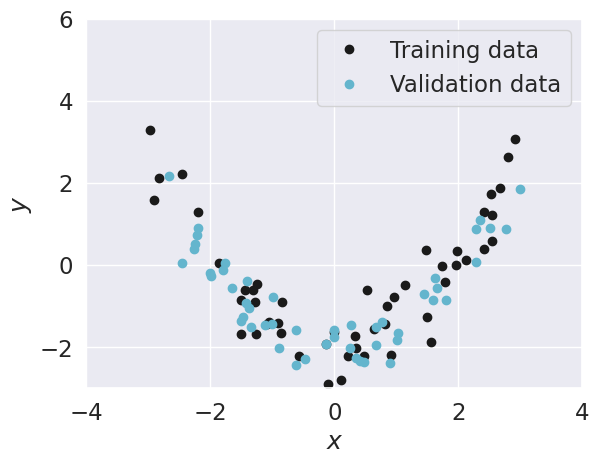

In [5]:
# load data
data = np.load('assignment3_data.npz')
N, X, y = data['N'], data['X'], data['y']
Nval, Xval, yval = data['Nval'], data['Xval'], data['yval']

plt.plot(X, y, 'k.', markersize=12, label='Training data')
plt.plot(Xval, yval, 'c.', label='Validation data', markersize=12)
plt.grid(True)
plt.xlim((-4, 4))
plt.ylim((-3, 6))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

Implement the squared exponential kernel and posterior function below (**you can copy-paste it from Assignment #2 directly**).

In [6]:
def create_se_kernel(X1, X2, alpha=1, scale=1):
    """ returns the NxM kernel matrix between the two sets of input X1 and X2 
    
    arguments:
    X1    -- NxD matrix
    X2    -- MxD matrix
    alpha -- scalar 
    scale -- scalar
    
    returns NxM matrix    
    """
    
    # YOUR CODE HERE
    prematrix = np.ones((X1.shape[0], X2.shape[0]))
    for i in range(X1.shape[0]):
        for j in range(X2.shape[0]):
            prematrix[i,j] = alpha* np.exp(-0.5*1/(scale**2)*(X1[i] - X2[j])**2)
    
    # YOUR CODE HERE
    return prematrix


In [7]:
def posterior(Xp, X, y, alpha, scale, sigma2):
    """ returns the posterior distribution of f evaluated at each of the points in Xp conditioned on (X, y)
        using the squared exponential kernel.
    
    Arguments:
    Xp    -- PxD prediction points
    X     -- NxD input points
    y     -- Nx1 observed values 
    alpha -- hyperparameter
    scale -- hyperparameter
    sigma2 -- noise variance
    
    returns Px1 mean vector and PxP covariance matrix
    """
    
    # YOUR CODE HERE
    kernelmatrixff = create_se_kernel(X, X, alpha, scale)
    kernelmatrixff += sigma2*np.identity(X.shape[0])
    kernelmatrixff_inv = np.linalg.inv(kernelmatrixff)
    kernelmatrixfpf = create_se_kernel(Xp, X, alpha, scale)
    mu = kernelmatrixfpf @ kernelmatrixff_inv @ y
    ## now lets calculate the covariance matrix
    kernelmatrixfpfp = create_se_kernel(Xp, Xp, alpha, scale)
    Sigma = kernelmatrixfpfp - kernelmatrixfpf @ kernelmatrixff_inv @ kernelmatrixfpf.T
    
    return mu, Sigma

**Task 1a:** Complete the implementation of the function <tt>predictive</tt> below. The predictive distribution of $(X_p, y_p)$ combines prediction function posterior (<tt>posterior</tt>) and the noise variance.

In [8]:
def predictive(Xp, X, y, alpha, scale, sigma2):
    """ returns the predictive distribution of yp evaluated at each of the points in Xp conditioned on (X, y)
    
    Arguments:
    Xp    -- PxD prediction points
    X     -- NxD input points
    y     -- Nx1 observed values 
    alpha -- hyperparameter
    scale -- hyperparameter
    sigma2 -- noise variance
    
    returns Px1 mean vector and PxP covariance matrix
    """
    # YOUR CODE HERE
    mu, Sigma = posterior(Xp, X, y, alpha, scale, sigma2)
    Sigma += sigma2*np.identity(Xp.shape[0])
    return mu, Sigma


In [9]:
Xp_test = np.linspace(-1, 1, 2)[:, None]
X_test = np.array([0.09, 0.40]).reshape((-1, 1))
y_test = np.array([0.59, 0.60]).reshape((-1, 1))

expected_m = np.array([[0.40882346], [0.46350769]])
expected_S = np.array([[ 0.41300352, -0.01397061], [-0.01397061,  0.33694137]])

m, S = posterior(Xp_test, X_test, y_test, .5, 2, 0.2)
print(m)
print("#"*10)
print(S)

[[0.40882346]
 [0.46350769]]
##########
[[ 0.21300352 -0.01397061]
 [-0.01397061  0.13694137]]


/tmp/ipykernel_38326/292602096.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prematrix[i,j] = alpha* np.exp(-0.5*1/(scale**2)*(X1[i] - X2[j])**2)


#### Let's test the above function

In [10]:
Xp_test = np.linspace(-1, 1, 2)[:, None]
X_test = np.array([0.09, 0.40]).reshape((-1, 1))
y_test = np.array([0.59, 0.60]).reshape((-1, 1))

expected_m = np.array([[0.40882346], [0.46350769]])
expected_S = np.array([[ 0.41300352, -0.01397061], [-0.01397061,  0.33694137]])

m, S = predictive(Xp_test, X_test, y_test, 0.5, 2, 0.2)


assert m.shape == expected_m.shape
assert S.shape == expected_S.shape
assert np.allclose(m.reshape(-1), expected_m.reshape(-1))
assert np.allclose(S.reshape(-1), expected_S.reshape(-1))


/tmp/ipykernel_38326/292602096.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prematrix[i,j] = alpha* np.exp(-0.5*1/(scale**2)*(X1[i] - X2[j])**2)


### Do not move or delete the below block. It is used for automatic grading.

**Task 1b**: Complete the implementation of the function <tt>MLPPD</tt> for computing the mean log posterior predictive density.


In [17]:
def MLPPD(yval, mu, Sigma):
    """ returns the mean log posterior predictive density for the data points (Xval, yval) wrt. predictive density N(mu, sigma)
    
    Arguments:
    yval      -- px1 observed values 
    mu        -- Px1 mean of predictive distribution
    Sigma     -- PxP covariance of predictive distribution

    Returns
        mlppd     -- (scalar) mean log posterior predictive density
    """
    # YOUR CODE HERE
    
    mlppd = 0
    
    
    for i in range(yval.shape[0]):
        mlppd += -0.5*np.log(2*np.pi*Sigma[i,i]) - 0.5*(yval[i] - mu[i])**2/Sigma[i,i]

    mlppd = mlppd
    return mlppd



In [18]:
Xp_test = np.linspace(-1, 1, 2)[:, None]
X_test = np.array([0.09, 0.40]).reshape((-1, 1))
y_test = np.array([0.59, 0.60]).reshape((-1, 1))

expected_m = np.array([[0.40882346], [0.46350769]])
expected_S = np.array([[ 0.41300352, -0.01397061], [-0.01397061,  0.33694137]])

mlppd_val = MLPPD(y_test, expected_m, expected_S)
mlppd_val

array([-0.91918959])

#### Let's test the above function

In [41]:
Xp_test = np.linspace(-1, 1, 2)[:, None]
X_test = np.array([0.09, 0.40]).reshape((-1, 1))
y_test = np.array([0.59, 0.60]).reshape((-1, 1))

expected_m = np.array([[0.40882346], [0.46350769]])
expected_S = np.array([[ 0.41300352, -0.01397061], [-0.01397061,  0.33694137]])

mlppd_val = MLPPD(y_test, expected_m, expected_S)

assert isinstance(mlppd_val, float)
assert np.allclose(mlppd_val, -0.9210686)

AssertionError: 

### Do not move or delete the below block. It is used for automatic grading.

**Task 1c**: Complete the implementation of the function <tt>log_marginal_likelihood</tt>  given below.

In [ ]:
def log_marginal_likelihood(X, y, alpha, scale, sigma2):
    """ returns the log marginal likelihood for the data set (X, y) for the hyperparameters alpha, scale, sigma2
        The function also returns the components of the log marginal likelihood:
        
        log_ml = const_term + det_term + quad_term
    
    Arguments:
    X        -- N x D input points
    y        -- N x 1 observed values 
    alpha    -- alpha parameter
    scale    -- scale parameter
    sigma2   -- noise variance

    Returns:
    log_ml   -- (scalar) log marginal likelihood ( = const + det + quad) with dtype float.
    const    -- constant part of the log marginal likelihood with dtype float.
    det      -- determinant part of the log marginal likelihood with dtype float.
    quad     -- quadratic part of the log marginal likelihood with dtype float.
    
    """
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return log_ml, const_term, det_term, quad_term



#### Let's test the above function

In [ ]:
Xp_test = np.linspace(-1, 1, 2)[:, None]
X_test = np.array([0.09, 0.40]).reshape((-1, 1))
y_test = np.array([0.59, 0.60]).reshape((-1, 1))

log_ml, const_term, det_term, quad_term = log_marginal_likelihood(X_test, y_test, 0.5, 2, 0.2)

assert isinstance(log_ml, float)
assert isinstance(const_term, float)
assert isinstance(det_term, float)
assert isinstance(quad_term, float)

assert np.allclose(log_ml, -1.433149)
assert np.allclose(const_term, -1.837877)
assert np.allclose(det_term, 0.7013446)
assert np.allclose(quad_term, -0.296617)

### Do not move or delete the below block. It is used for automatic grading.

**Task 1d**: Compute and plot the marginal likelihood as a function of the scale parameter in the interval $\left[0.01, 100\right]$ using the scales vector (<tt>scales</tt>) given below. In the same figure, you should plot the determinant and the quadratic part of the marginal likelihood. Note that the scale values are distributed equally in log space. Use $\sigma^2 = 0.5$ and $\alpha=1$. The scale axis should be logarithmic in the plot. Furthermore, locate the optimal value of the scale and plot the posterior distribution of $f(\bf{X}_p)$ for the optimal value.

In [ ]:
# NOTE: This block contains supporting functions used for plotting. These are complete, and nothing needs to be done here.

def plot_with_uncertainty(Xp, mu, Sigma, color='r', color_samples='b', title="", num_samples=0):
    mean, std = mu.ravel(), np.sqrt(np.diag(Sigma))
    # plot distribution
    plt.plot(Xp, mean, color=color, label='Mean')
    plt.plot(Xp, mean + 2*std, color=color, linestyle='--')
    plt.plot(Xp, mean - 2*std, color=color, linestyle='--')
    plt.fill_between(Xp.ravel(), mean - 2*std, mean + 2*std, color=color, alpha=0.25, label='Confidence')

    def generate_samples(mean, K, M):
        L = np.linalg.cholesky(K + 1e-8 * np.identity(len(K)))
        zs = np.random.normal(0, 1, size=(len(K), M))
        fs = mean + np.dot(L, zs)
        return fs
    
    # generate samples
    if num_samples > 0:
        fs = generate_samples(mu, Sigma, 10)
        plt.plot(Xp, fs, color=color_samples, alpha=.25)
    
    plt.title(title)
    
def plot_data():
    plt.plot(X, y, 'k.', markersize=15, label='Data')
    plt.xlabel('Input x')
    plt.ylim((-5, 5))
    plt.grid(True)

In [ ]:
def plot_ml_scale_grid():
    scales = np.logspace(-2, 2, 100)
    sigma2 = 0.5
    alpha = 1
    Xp = np.linspace(-3, 9, N)[:, None]  # Used for plotting the posterior
    
    log_ml_values = None # TASK: Calculate this for X, y, alpha, scales, and sigma2 values.
    const = None  # TASK: Calculate this for X, y, alpha, scales, and sigma2 values.
    det = None  # TASK: Calculate this for X, y, alpha, scales, and sigma2 values.
    quad = None # TASK: Calculate this for X, y, alpha, scales, and sigma2 values.
    optimal_scale_mll = None  # TASK: Calculate the optimal scale value based on the log marginal likelihood value.
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    print(f"Optimal value is {optimal_scale_mll}")
    
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.semilogx(scales, log_ml_values, label='Log ML', linewidth=3.)
    plt.semilogx(scales, const, '--', label='Const')
    plt.semilogx(scales, det, '--', label='Determinant term')
    plt.semilogx(scales, quad, '--', label='Quadractic term')
    plt.xlabel('Scale')
    plt.ylabel('Marginal likelihood')
    plt.grid(True)
    
    plt.plot([optimal_scale_mll, optimal_scale_mll],[min(min(const,det,quad,log_ml_values)), 
                                            max(max(const,det,quad,log_ml_values))], label='Optimal scale')
    plt.legend(loc='lower left')
    
    mu_post, Sigma_post = posterior(Xp, X, y, alpha, optimal_scale_mll, sigma2)
    plt.subplot(1, 2, 2)
    plot_data()
    plt.plot(Xval, yval, 'c.', label='Validation data', markersize=12)
    plot_with_uncertainty(Xp, mu_post, Sigma_post, title='Posterior at optimal scale for marginal likelihood', num_samples=10)
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
if not automatic_grading:
    plot_ml_scale_grid()

##### Q: What is the optimal scale value (approximately) according to the marginal likelihood?

**1)** 0.87

**2)** 1.00

**3)** 1.84

**4)** 2.42


In [ ]:
a_1d = None  # TASK: Replace None with your answer (1, 2, 3, 4)

In [ ]:
assert a_1d in [1, 2, 3, 4]

### Do not move or delete the below block. It is used for automatic grading.

**Task 1e**: Compute and plot the MLPPD of the validation set $\left( \bf{X}_{\text{val}}, \bf{y}_{\text{val}}\right)$ as a function of the scale parameter in the interval $\left[0.01, 100\right]$ using the scales vector (<tt>scales</tt>) given below. Note that the scale values are distributed equally in log space. Use $\sigma^2 = 0.5$ and $\alpha=1$. The scale axis should be logarithmic in the plot. Furthermore, locate the optimal value of the scale and plot the posterior distribution of $f(\bf{X}_p)$ for the optimal value.

In [ ]:
def plot_mlppd_scale_grid():
    scales = np.logspace(-2, 2, 50)
    sigma2 = 0.5
    alpha = 1
    Xp = np.linspace(-3, 9, N)[:, None]  # Used for plotting the posterior
    
    MLPPD_values = None  # TASK: Calculate the MLPPD values: alpha, scales, sigma2, X, y, Xval, yval
    optimal_scale_mlppd = None  # TASK: Calculate the optimal scale value based on the MLPPD value.
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    print(f"Optimal value is {optimal_scale_mlppd}")
    
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.semilogx(scales, MLPPD_values, label='MLPPD', linewidth=3.)
    plt.xlabel('Scale')
    plt.ylabel('MLPPD')
    plt.grid(True)
    
    plt.plot([optimal_scale_mlppd, optimal_scale_mlppd],[min(MLPPD_values), max(MLPPD_values)], label='Optimal scale')
    plt.legend(loc='lower left')
    
    mu_post, Sigma_post = posterior(Xp, X, y, alpha, optimal_scale_mlppd, sigma2)
    plt.subplot(1, 2, 2)
    plot_data()
    plt.plot(Xval, yval, 'c.', label='Validation data', markersize=12)
    plot_with_uncertainty(Xp, mu_post, Sigma_post, title='Posterior at optimal scale for mean log posterior predictive density', num_samples=10)
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
if not automatic_grading:
    plot_mlppd_scale_grid()

##### Q: What is the optimal scale value (approximately) according to the MLPPD?

**1)** 0.86

**2)** 1.00

**3)** 1.84

**4)** 2.33


In [ ]:
a_1e = None  # TASK: Replace None with your answer (1, 2, 3, 4)

In [ ]:
assert a_1e in [1, 2, 3, 4]

### Do not move or delete the below block. It is used for automatic grading.

**Task 1f**: Are the optimal scale values in the above plots the same? Answer the **True-False** question and explain why.

In [ ]:
a_1f = None  # TASK: Replace None with your answer True or False

**Explanation:** {Write your answer here}

In [ ]:
assert isinstance(a_1f, bool)

### Do not move or delete the below block. It is used for automatic grading.

### Task 2: Periodic Kernel (1 point)

The aim of this task is to implement the Periodic kernel, and compare it with the Squared Exponential Kernel.

### Task 2a: Implement the periodic kernel below.

$$ K_{ij} = \alpha \cdot \exp\left(-\frac{2 \sin^2\left(\frac{\pi D^2_{ij}}{T}\right)}{s^2}\right) $$

where $D^2_{ij}$ refers to the squared Euclidean distance between $x_i$ and $x_j$.

In [ ]:
def create_periodic_kernel(X1, X2, alpha=1, scale=1, period=1):
    """ returns the NxM kernel matrix between the two sets of input X1 and X2 using the periodic kernel.
    
    Arguments:
    
    X1    -- NxD matrix
    X2    -- MxD matrix
    alpha -- scalar 
    scale -- scalar
    period -- scalar
    
    returns NxM matrix    
    """
    
    # YOUR CODE HERE
    raise NotImplementedError()

### Let's test the function

In [ ]:
X1 = np.array([0.87, 0.55]).reshape((2, 1))
X2 = np.array([0.50, 0.28]).reshape((2, 1))
alpha = .5
scale = 1.5
period = .8

expected_kernel_val = np.array([[0.3960411, 0.2131794], [0.4999572, 0.4657867]])
kernel_val = create_periodic_kernel(X1, X2, alpha, scale, period)

assert kernel_val.shape == expected_kernel_val.shape
np.testing.assert_almost_equal(expected_kernel_val, kernel_val)

### Do not move or delete the below block. It is used for automatic grading.

### Let us generate some toy data, plot the covariance for different kernels, and study its properties.

In [ ]:
def create_sin_data():
    """Create the Sin data."""
    X_sine = np.linspace(0, 10, 50).reshape((-1, 1))    
    y_sine = np.sin(X_sine)
    return X_sine, y_sine

In [ ]:
X_sine, y_sine = create_sin_data()

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].plot(X_sine, y_sine, "k.")
axs[0].set_xlabel('X')
axs[0].set_ylabel('y')
axs[0].grid(True)

K_periodic = create_periodic_kernel(X_sine, X_sine, alpha=1.0, scale=.1, period=4.)
axs[1].imshow(K_periodic, extent=(0, 10, 10, 0), cmap="viridis")
axs[1].set_title("Periodic Kernel")

K_se = create_se_kernel(X_sine, X_sine, alpha=1.0, scale=.1)
axs[2].imshow(K_se, extent=(0, 10, 10, 0), cmap="viridis")
axs[2].set_title("Squared Exponential Kernel")

plt.show()

### Task 2b: For the toy data generated above, on the basis of the covariance matrix, which kernel is a better choice for modelling? Explain!

**1)** Periodic Kernel

**2)** Squared Exponential Kernel

In [ ]:
a_2b = None  # TASK: Replace None with your answer (1, 2)

**Explanation:** {Write your answer here}

In [ ]:
assert a_2b in [1, 2]

### Do not move or delete the below block. It is used for automatic grading.

### Task 3: Kernel ridge regression (2 points)

The aim of this task is to compute the solution to the Kernel ridge regression problem using *scipy.optimize* and compare it to the analytical solution.

In [ ]:
# This block generates toy data. Nothing to do here.

# Generate the toy data
n = 100
x_ridge = np.linspace(0, 10, n).reshape((n, 1))
y_ridge = np.sin(x_ridge)
y_ridge = y_ridge.reshape(-1) + 0.1 * np.random.randn(n)

K_ridge = create_se_kernel(x_ridge, x_ridge)

lambda_val = 2

**Task 3a.** Implement the objective of the kernel ridge regression in the function below.

In [ ]:
def ridge_obj(alpha, K, y, lambda_val) -> float:
    """
    Implement the kernel ridge regression objective and return the float value.
    """
    # YOUR CODE HERE
    raise NotImplementedError()

#### Let's test the above function

In [ ]:
alpha = np.ones((100))
val = ridge_obj(alpha, K_ridge, np.sin(x_ridge).reshape((-1,)), lambda_val)

assert isinstance(val, float)
assert np.allclose(val, 57049.835187)

### Do not move or delete the below block. It is used for automatic grading.

Now, we will optimize the ridge objective using the *scipy.minimize* function.

In [ ]:
from scipy.optimize import minimize
if not automatic_grading:
    r = minimize(ridge_obj, np.random.rand(n), args=(K_ridge, y_ridge, lambda_val))
    assert r.success == True
    optimized_alpha_value = r.x    

**Task 3b:** Implement the numerical solution.

In [ ]:
def numerical_solution(K, optimized_alpha_value):
    # YOUR CODE HERE
    raise NotImplementedError()

#### Let's test the above function

In [ ]:
xtest = 0.15 * np.ones((2, 1))
ytest = 0.43 * np.ones((2, 1))
K_test = create_se_kernel(xtest, xtest)
alpha_value_test = np.array([[0.435], [0.435]])

expected_val = K_test @ alpha_value_test
val = numerical_solution(K_test, alpha_value_test)

assert np.allclose(val, expected_val)

### Do not move or delete the below block. It is used for automatic grading.

**Task 3c:** Implement the analytical solution.

In [ ]:
def analytical_solution(K, lambda_val, y):
    # YOUR CODE HERE
    raise NotImplementedError()

#### Let's test the above function

In [ ]:
xtest = 0.15 * np.ones((2, 1))
ytest = 0.43 * np.ones((2, 1))
K_test = create_se_kernel(xtest, xtest)
expected_val = np.array([[0.215], [0.215]])
val = analytical_solution(K_test, lambda_val, ytest)

assert np.allclose(val, expected_val)

### Do not move or delete the below block. It is used for automatic grading.

Let's plot both the solutions

In [ ]:
if not automatic_grading:
    plt.figure(figsize=(12, 6))
    plt.plot(x_ridge, y_ridge, 'r+', markersize=5, label=u'Observations')
    
    plt.plot(x_ridge, numerical_solution(K_ridge, optimized_alpha_value), 'r-', label='Numerical Solution')
    plt.plot(x_ridge, analytical_solution(K_ridge, lambda_val, y_ridge), 'b--', label = 'Analytical Solution')
    
    plt.xlabel('Input, $x$')
    plt.ylabel('Output, $y$')
    plt.legend()
    plt.show()

**Task 3d:** Is the analytical solution same (approximately) as the numerical solution obtained by using *scipy.optimize*?

In [ ]:
a_3d = None  # TASK: Replace None with True or False

In [ ]:
assert isinstance(a_3d, bool)

### Do not move or delete the below block. It is used for automatic grading.

### Task 4: After answering all the questions, kindly set `automatic_grading=True` at the top of the notebook, use the validate option in the toolbar to validate the notebook and be sure that there are no errors.